In [1]:
import os
import cv2
import openpyxl
import pandas as pd
from random import shuffle
from mtcnn import MTCNN
from tqdm import tqdm
import numpy as np

# Face Detection and Dataset Generator

In [18]:
detector = MTCNN()

cap = cv2.VideoCapture(0)
id = 1
name = "Bharat"
img_id = 41
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to capture frame from webcam.")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # input_faces = face_classifier.detectMultiScale(gray, 1.1, 5)
    input_faces = detector.detect_faces(rgb_frame)


    for face in input_faces:
        x, y, width, height = face['box']
        cropped_face = gray[y:y+height, x:x+width]
        # cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 155, 255), 2)
        img_id += 1
        face = cv2.resize(cropped_face, (150, 150))
        # file_name_path = f"DataSet/{name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
        file_name_path = f"visualization/{name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
        cv2.imwrite(file_name_path, face)
        cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
    # for (x, y, w, h) in input_faces:
    #     cropped_face = frame[y:y+h, x:x+w]
    #     img_id += 1
    #     face = cv2.resize(cropped_face, (150, 150))
    #     file_name_path = f"DataSet/{name}" + "." + str(id) + "."+ str(img_id) + ".jpg"
    #     cv2.imwrite(file_name_path, face)
    #     cv2.putText(face, str(img_id), (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("Cropped Face", face)
        if cv2.waitKey(1) == ord('q') or img_id == 20:
            break
cap.release()
cv2.destroyAllWindows()
print("DataSet Successfully Generated")

KeyboardInterrupt: 

In [2]:
def my_label(image_name):
    name = image_name.split('.')[0]
    if name == "Bharat":
        return np.array([1,0,0])
    elif name == "Shyam":
        return np.array([0,1,0])
    elif name == "Khedup":
        return np.array([0,0,1])
        

# Feature Engineering

In [3]:
def my_data():
    data= []
    for img in tqdm(os.listdir("DataSet")):
        path = os.path.join("DataSet", img)
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50, 50))
        data.append([np.array(img_data), my_label(img)])
    shuffle(data)
    return data

# Train and Test Split

In [4]:
data = my_data()
train = data[:240]
test = data[240:]
X_train = np.array([i[0] for i in train]).reshape(-1,50,50,1)
y_train = np.array([i[1] for i in train])
X_test = np.array([i[0] for i in test]).reshape(-1,50,50,1)
y_test = np.array([i[1] for i in test])
print(X_train.shape)
print(X_test.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1019.16it/s]

(240, 50, 50, 1)
(60, 50, 50, 1)


In [5]:
# for i in train: print(np.argmax(i[1]))

# Model

In [6]:
import warnings
warnings.filterwarnings("ignore")
from PIL import Image as pil
from pkg_resources import parse_version

if parse_version(pil.__version__)>=parse_version('10.0.0'):
    pil.ANTIALIAS=pil.LANCZOS

import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)



In [35]:
class MetricsCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.train_acc = []
        self.val_acc = []
        self.train_loss = []
        self.val_loss = []

    def on_epoch_end(self, training_state):
        self.train_acc.append(training_state.acc_value)
        self.val_acc.append(training_state.val_acc_value)
        self.train_loss.append(training_state.loss_value)
        self.val_loss.append(training_state.val_loss_value)
tf.compat.v1.reset_default_graph()
convnet = input_data(shape=[50, 50, 1])
convnet = conv_2d(convnet, 32, 5, activation= 'relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 3, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = 0.001, loss='categorical_crossentropy')
model = tflearn.DNN(convnet, tensorboard_verbose=1)
metrics_callback = MetricsCallback()
model.fit(X_train, y_train, n_epoch=12, validation_set=(X_test, y_test), show_metric = True, run_id="FRS" )
train_acc = metrics_callback.train_acc
val_acc = metrics_callback.val_acc
train_loss = metrics_callback.train_loss
val_loss = metrics_callback.val_loss
print("Training Accuracy:", train_acc)
print("Validation Accuracy:", val_acc)
print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)

Training Step: 47  | total loss: 0.66344 | time: 0.287s
| Adam | epoch: 012 | loss: 0.66344 - acc: 0.8497 -- iter: 192/240
Training Step: 48  | total loss: 0.56395 | time: 1.381s
| Adam | epoch: 012 | loss: 0.56395 - acc: 0.8713 | val_loss: 0.05393 - val_acc: 0.9833 -- iter: 240/240
--
Training Accuracy: []
Validation Accuracy: []
Training Loss: []
Validation Loss: []


In [31]:
metrics_callback = MetricsCallback()
train_acc = metrics_callback.train_acc
val_acc = metrics_callback.val_acc
train_loss = metrics_callback.train_loss
val_loss = metrics_callback.val_loss

In [33]:
print(val_loss)

[]


# Feature Engineering for Predicting 

In [10]:
acc = history.accuracy
val_acc = history.val_accuracy

loss = history.loss
val_loss = history.val_loss

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

AttributeError: 'NoneType' object has no attribute 'accuracy'

In [11]:
def data_for_visualization():
    Vdata = []
    for img in tqdm(os.listdir("visualization")):
        path = os.path.join("visualization", img)
        img_num = img.split('.')[0] 
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        Vdata.append([np.array(img_data), img_num])
    shuffle(Vdata)
    return Vdata

100%|████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2349.53it/s]


ValueError: num must be an integer with 1 <= num <= 1, not 2

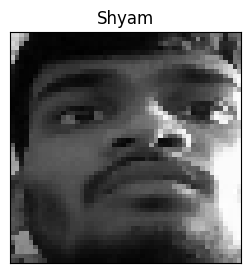

In [26]:
import matplotlib.pyplot as plt   # installation command: pip install matplotlib
Vdata = data_for_visualization()
fig = plt.figure(figsize=(6,3))
for num, data in enumerate(Vdata[0:]):
    img_data = data[0]
    y = fig.add_subplot(1,1, num+1)
    image = img_data
    data = img_data.reshape(50,50,1)
    model_out = model.predict([data])[0]
    # print(model_out)
     
    if np.argmax(model_out) == 0:
        my_label = 'Bharat'
    elif np.argmax(model_out) == 1:
        my_label = 'Shyam'
    else:
        my_label = 'Khedup'

    # f = plt.figure(figsize=(6, 3))
    plt.imshow(image, cmap= 'gray')
    plt.title(my_label)
    
    file_path = 'Attendance_Log.xlsx'
    workbook = openpyxl.load_workbook(file_path)
    sheet = workbook.active 
    # Update a cell value
    sheet['A1'] = f'{my_label}'
    sheet['B1'] = 'Present'
    workbook.save(file_path)
    
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

